In [77]:
import numpy as np
import heapq
import random
import math
import pprint
import matplotlib.pyplot as plt
import time
import queue
Distance = [[0,1064,673,1401,277],
            [1064,0,958,1934,377],
            [673,957,0,1001,399],
            [1401,1934,1001,0,387],
            [277,377,399,387,0]]
Distance_cpy = [[0,1064,673,1401,277],
            [1064,0,958,1934,377],
            [673,957,0,1001,399],
            [1401,1934,1001,0,387],
            [277,377,399,387,0]]
W_ = {1:{1:'A',2:'E',3:'D',4:'C',5:'A'},
        2:{1:'B',2:'E',3:'A',4:'C',5:'D'},
        3:{1:'B',2:'A',3:'B',4:'C',5:'E'},
        4:{1:'D',2:'A',3:'D',4:'B',5:'D'},
        5:{1:'B',2:'E',3:'C',4:'B',5:'D'}}
Starting_Point = ['A','B','C','D','E']
fac_dict = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4}
rev_fac_dict = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E'}
mp ={}

In [125]:
def diff(a,b):
    c = []
    for num, i in enumerate(a):
        c.append(abs(i-b[num]))
    return c

In [78]:
def extract_distance():
    for i in Starting_Point:
        dd = 20000
        for j in Starting_Point:
            if get_gscore_dist(i,j)<dd and i != j:
                dd = get_gscore_dist(i,j)
                mp[i]=j
#     print(mp)
    for i in Starting_Point:
        for j in Starting_Point:
            if get_gscore_dist(i,j)>(get_gscore_dist(i,mp[i])+get_gscore_dist(mp[i],j)):
                Distance[fac_dict[i]][fac_dict[j]]=get_gscore_dist(i,mp[i])+get_gscore_dist(mp[i],j)
#     print(Distance)
def backup_distance():
    Distance = [[0,1064,673,1401,277],
                [1064,0,958,1934,377],
                [673,957,0,1001,399],
                [1401,1934,1001,0,387],
                [277,377,399,387,0]]

In [79]:
class node():
    def __init__(self, cur_factory,last_table, gscore=float('inf'),fscore=float('inf'), parent=''):
        self.gscore = gscore
        self.last_table = last_table
        self.cur_factory = cur_factory
        self.parent = parent
        self.fscore = fscore
    
    def __key(self):
        return (self.parent)
    
    def __eq__(self, other):
        return (np.array_equal(self.last_table,other.last_table) and self.gscore <= other.gscore)
    
    def __lt__(self, other):
        return self.fscore < other.fscore
    
    def __hash__(self):
        return hash(self.__key())

In [80]:
def get_table_dijk(node,factory,W):
    table = node.last_table.copy()
    for num, i in enumerate (table):
        for j in range(len(i)):
            if i[j] == 1:
                if W[num+1][j+1] == factory: i[j] = i[j] - 1
                break;
    return table, node.last_table.sum() == table.sum()

def h_min_dis(node,factory,W):
    table = node.last_table.copy()
    temp = node.cur_factory
    table2 = table.copy()
    table2 = table2.T
    fscore = 0
    for num, i in enumerate (table):
        if num < (len(table2)):
            if table2[num].sum() != 0:
                fscore=fscore+Distance[fac_dict[temp]][fac_dict[mp[temp]]]
                temp = mp[temp]
        for j in range(len(i)):
            if i[j] == 1:
                if W[num+1][j+1] == factory: i[j] = i[j] - 1
                break;
    return table,fscore,node.last_table.sum() == table.sum()                      
    
def h_min_step(node,factory,W):
    '''
    calculate the huristic of a certain step of node
    '''
    table = node.last_table.copy()
    table2 = table.copy()
    table2 = table2.T
    fscore = 0
    for num, i in enumerate (table):
        if num < (len(table2)):
            if table2[num].sum() != 0:fscore=fscore+1
        for j in range(len(i)):
            if i[j] == 1:
                if W[num+1][j+1] == factory: i[j] = i[j] - 1
                break;
    return table,fscore,node.last_table.sum() == table.sum()

def get_gscore_dist(city1,city2):
    return Distance[fac_dict[city1]][fac_dict[city2]]

def get_close(table):
    s = ''
    for i in table:
        j = i.sum()
        s = s+ str(int(j))
    return s

def get_step(a,b):
    return 1

def get_low_rank(open_set):
    min_huris = float('inf')
    for nodes in open_set:
        if (nodes.fscore)<min_huris:
            cur_node = nodes
            min_huris = cur_node.fscore  
    return cur_node

def goal_test(node):
    if node.last_table.sum() == 0: return True
    return False

In [ ]:
def A_star(start,hu,get_func,N=5,W=W_):
    node_expanded=1
    hu_table = np.ones((5,N))
    initnode = node(start,hu_table,gscore=0,fscore=25.0)
    table,fscore,tf = hu(initnode,start,W)
    start_node = node(start,table,gscore=0,fscore=fscore,parent=start)
    close_set = {}
    open_set = []
    heapq.heappush(open_set,start_node)
    cities = ['A','B','C','D','E']
    while len(open_set)!=0:
        cur_node = heapq.heappop(open_set) 
        if goal_test(cur_node): 
#             print('node expanded=',node_expanded)
            return cur_node.parent,node_expanded
        close_set[get_close(cur_node.last_table)]=cur_node.gscore
        for city in cities:
            if city == cur_node.cur_factory: continue
            table,fscore,tf = hu(cur_node,city,W)
            if(tf):continue
            cost = cur_node.gscore+get_func(cur_node.cur_factory,city)
            if get_close(table) in close_set:
                if close_set[get_close(table)] < cost:
                    continue
                close_set[get_close(table)] = cost
            new_node = node(city,table,gscore=cost,fscore=fscore+cost,parent=cur_node.parent+city)
            heapq.heappush(open_set,new_node)
            node_expanded = node_expanded + 1
    return

In [88]:
backup_distance()
for t in Starting_Point:
    lenn = 1000
    print('for starting =',t)
    retv,ex = A_star(t,h_min_step,get_step)
    dis = 0
#     for s in retv:
#         dis = dis + get_gscore_dist(t,s)
#         t = s
#     print(dis)
    print('temp=',retv)
    print('len=',len(retv))
    print()

for starting = A
temp= ABEDCADBCDE
len= 11

for starting = B
temp= BDAEDCBACDE
len= 11

for starting = C
temp= CBDAEDCBACED
len= 12

for starting = D
temp= DABEDCABCDE
len= 11

for starting = E
temp= EBDAEDCBACED
len= 12



In [93]:
extract_distance()
for t in Starting_Point:
    lenn = 1000
    print('for starting =',t)
    retv,ex = A_star(t,h_min_dis,get_gscore_dist)
    startttt = t
    dis = 0
    new_sequence = ''
    for s in retv:
        if get_gscore_dist(startttt,s) != Distance_cpy[fac_dict[startttt]][fac_dict[s]]:
            new_sequence = new_sequence + mp[s]
            new_sequence = new_sequence + s
        else:
            new_sequence = new_sequence + s
        dis = dis + get_gscore_dist(startttt,s)
        startttt = s
    print('distance =', dis)
    print(new_sequence)
    print()

for starting = A
distance = 5867
AEBEDECAEDEBECED

for starting = B
distance = 5726
BEDEAEDEBECEBEAED

for starting = C
distance = 6502
CEBEDEAEBEDECEBEAED

for starting = D
distance = 5716
DEBEAEBEDECEBEAED

for starting = E
distance = 6103
EBEDEAEBEDECEBEAED



In [82]:
def random_generator(N):
    tt = np.zeros((5,N))
    Generated = {1:{},
                2:{},
                3:{},
                4:{},
                5:{}}
    for i in range(N):
        for j in range(5):
            tt[j][i] = math.floor(random.random()*5)
            if i > 0:
                while tt[j][i] == tt[j][i-1]:
                    tt[j][i] = math.floor(random.random()*5)
            Generated[j+1][i+1] = rev_fac_dict[int(tt[j][i])]
    return Generated

In [98]:
total_step = []
N = 8
start = time.time()
for N in range(3,9):
#     for i in range(50):
    temp = 0
    W = random_generator(N)
#         pprint.pprint(W)
    retv,ndexpnd = A_star('A',h_min_step,get_step,N = N, W = W)
    temp = temp + ndexpnd
    total_step.append(temp)
    print('finish',N,'',time.time()-start)

finish 3  0.17184185981750488
finish 4  0.20747709274291992
finish 5  0.8863129615783691
finish 6  1.0728418827056885
finish 7  2.752150774002075
finish 8  40.22135400772095


In [99]:
total_step

[1412, 291, 5054, 1443, 10057, 220976]

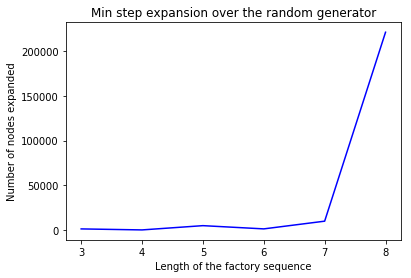

In [100]:
plt.plot(list(range(3,9)), total_step, 'b')
plt.axis()
plt.xlabel('Length of the factory sequence')
plt.ylabel('Number of nodes expanded')
plt.title('Min step expansion over the random generator')
plt.show()


In [101]:
total_dist = []
N = 8
start = time.time()
for N in range(3,9):
#     for i in range(50):
    temp = 0
    W = random_generator(N)
#         pprint.pprint(W)
    retv,ndexpnd = A_star(t,h_min_dis,get_gscore_dist,N = N, W = W)
    temp = temp + ndexpnd
    total_dist.append(temp/len(Starting_Point))
    print('finish',N,'',time.time()-start)

finish 3  0.016078948974609375
finish 4  0.3678619861602783
finish 5  0.5586121082305908
finish 6  1.0089399814605713
finish 7  5.579308032989502
finish 8  38.9700140953064


In [102]:
total_dist

[16.0, 371.0, 304.2, 628.0, 5293.6, 32120.4]

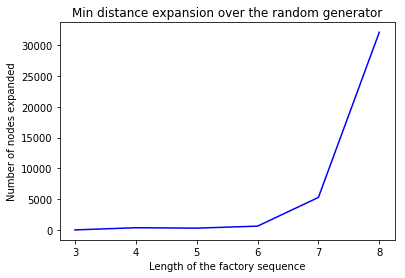

In [103]:
plt.plot(list(range(3,9)), total_dist, 'b')
plt.axis()
plt.xlabel('Length of the factory sequence')
plt.ylabel('Number of nodes expanded')
plt.title('Min distance expansion over the random generator')
plt.show()

In [38]:
backup_distance()
startttt = 'D'
dis = 0
for s in 'DEBEAEBEDECAEBED':
    if get_gscore_dist(startttt,s) != Distance_cpy[fac_dict[startttt]][fac_dict[s]]:
        new_sequence = new_sequence + mp[s]
        new_sequence = new_sequence + s
    else:
        new_sequence = new_sequence + s
    dis = dis + get_gscore_dist(startttt,s)
    startttt = s

In [39]:
print(dis)

5713


In [104]:
def Uniform(start,N=5,W=W_):
    hu_table = np.ones((5,N))
    node_expanded=1
    initnode = node(start,hu_table,fscore=0)
    table,tf = get_table_dijk(initnode,start,W)
    start_node = node(start,table,fscore=0,parent=start)
    close_set = set()
    open_set = []
    heapq.heappush(open_set,start_node)
    cities = ['A','B','C','D','E']
    while open_set.qsize()!=0:
        cur_node = heapq.heappop(open_set)
        if goal_test(cur_node): 
#             print('node expanded=',node_expanded)
            return cur_node.parent,node_expanded
        close_set.add(cur_node)
        for city in cities:
            if city == cur_node.cur_factory: continue
            table,tf = get_table_dijk(cur_node,city,W)
            if(tf):continue
            cost = cur_node.fscore+get_gscore_dist(cur_node.cur_factory,city)
            new_node = node(city,table,fscore=cost,parent=cur_node.parent+city)
            if new_node in close_set: 
                if new_node.last_table 
            open_set.put(new_node)
            node_expanded = node_expanded + 1
    return

In [116]:
total_uni = []
N = 8
start = time.time()
for N in range(3,9):
#     for i in range(50):
    temp = 0
    W = random_generator(N)
#         pprint.pprint(W)
    retv,ndexpnd = Uniform('A',N = N, W = W)
    temp = temp + ndexpnd
    total_uni.append(temp)
    print('finish',N,'',time.time()-start)

finish 3  0.036228179931640625
finish 4  1.2168350219726562


KeyboardInterrupt: 

In [130]:
total_uni

[837, 799, 123762, 54487, 2141711, 31345342]

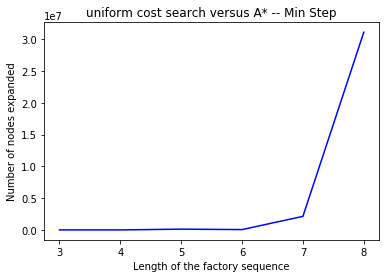

In [137]:
k = diff(total_step,total_uni)
plt.plot(list(range(3,9)), k, 'b')
plt.axis()
plt.xlabel('Length of the factory sequence')
plt.ylabel('Number of nodes expanded')
plt.title('uniform cost search versus A* -- Min Step')
plt.show()

In [131]:
total_uni_dis = []
N = 8
extract_distance()
start = time.time()
for N in range(3,9):
#     for i in range(50):
    temp = 0
    W = random_generator(N)
#         pprint.pprint(W)
    retv,ndexpnd = Uniform('A',N = N, W = W)
    temp = temp + ndexpnd
    total_uni_dis.append(temp)
    print('finish',N,'',time.time()-start)

finish 3  0.02083301544189453
finish 4  0.05559182167053223
finish 5  1.4916229248046875
finish 6  17.336442947387695


KeyboardInterrupt: 

In [135]:
total_uni_dis

[210, 460, 28139, 360324, 2087651, 9553176]

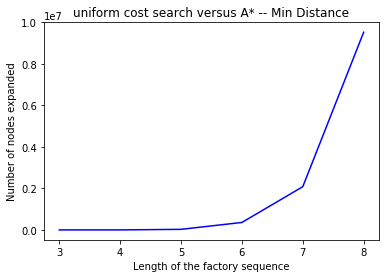

In [138]:
k_2 = diff(total_dist,total_uni_dis)
plt.plot(list(range(3,9)), k_2, 'b')
plt.axis()
plt.xlabel('Length of the factory sequence')
plt.ylabel('Number of nodes expanded')
plt.title('uniform cost search versus A* -- Min Distance')
plt.show()